In [75]:
# INSTALL DEPENDENCIES
%pip install matplotlib numpy pandas keras scikit-learn opencv-python tensorflow pillow seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [76]:
# IMPORTS
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from PIL import Image
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping

In [77]:
# CONSTANTS
DATASET_PATH = './data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed'
MOISTURE_LEVEL_CLASSES = os.listdir(DATASET_PATH)
CLASSES = len(MOISTURE_LEVEL_CLASSES)

print(MOISTURE_LEVEL_CLASSES)

['Dry', 'Highest_moisture', 'Moderate_moisture', 'processed']


In [78]:
# UTILS
def viewImage(image):
    plt.clf()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [79]:
# HYPERPARAMETERS
class HyperParameter:
    IMG_SIZE = 64
    IMG_CHANNELS = 3
    MODEL_OPTIMIZER = 'adam'
    MODEL_LOSS_FUNCTION = 'sparse_categorical_crossentropy'
    EPOCHS = 10
    INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
    ALLOWED_IMAGE_EXTENSIONS = ['png', 'jpg', 'jpeg']
    TRAIN_BATCH_SIZE = 32
    TRAIN_DATA_SIZE = 0.7
    VAL_DATA_SIZE = 0.2
    TEST_DATA_SIZE = 0.1
    COLOR_MODE = 'rgb'


In [80]:
# IMAGE PREPROCESSING
os.makedirs(os.path.join(DATASET_PATH, 'processed'), exist_ok=True)
for image_class in os.listdir(DATASET_PATH):
    os.makedirs(os.path.join(DATASET_PATH, 'processed', image_class), exist_ok=True)
    for image in os.listdir(os.path.join(DATASET_PATH, image_class)):
        image_path = os.path.join(DATASET_PATH, image_class, image)
        processed_image_path = os.path.join(DATASET_PATH, 'processed', image_class, image)
        try:
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (HyperParameter.IMG_SIZE, HyperParameter.IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            with Image.open(image_path) as img_meta:
                tip = img_meta.format.lower()
                if tip not in HyperParameter.ALLOWED_IMAGE_EXTENSIONS:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
                else:
                    cv2.imwrite(processed_image_path, img)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image ./data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed\processed\Dry
Issue with image ./data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed\processed\Highest_moisture
Issue with image ./data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed\processed\Moderate_moisture
Issue with image ./data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed\processed\processed


In [81]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DATASET_PATH}/processed",
    image_size=(HyperParameter.IMG_SIZE, HyperParameter.IMG_SIZE),
    color_mode=HyperParameter.COLOR_MODE,
)
data = data.map(lambda x, y: (x / 255, y))
data_iterator = data.as_numpy_iterator()

Found 15002 files belonging to 4 classes.


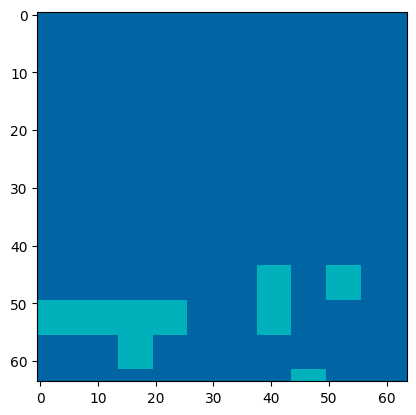

In [82]:
viewImage(data_iterator.next()[0][0])

In [83]:
train_size = int(len(data) * HyperParameter.TRAIN_DATA_SIZE)
val_size = int(len(data) * HyperParameter.VAL_DATA_SIZE)
test_size = int(len(data) * HyperParameter.TEST_DATA_SIZE)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [84]:
def identity_block(X, f, filters, stage, block):
    """
    @param X: input of shape (m, height, width, channel)
    @param f: shape of the middle CONV's window for the main path
    @param filters: python list of integers, defining the number of filters in the CONV layers of the main path
    @param stage: integer, used to name the layers, depending on their position in the network
    @param block: string/character, used to name the layers, depending on their position in the network

    Returns:
    X: output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [85]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X


    # First layer
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)


    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [86]:
def ResNet50(input_shape=(64, 64, 3), classes=3):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # output FC layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [87]:
model = ResNet50(input_shape = HyperParameter.INPUT_SHAPE, classes = CLASSES)

In [88]:
model.compile(optimizer=HyperParameter.MODEL_OPTIMIZER, loss=HyperParameter.MODEL_LOSS_FUNCTION, metrics=['accuracy'])

In [89]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 70, 70, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │      9,472 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 32, 32,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_196      │ (None, 32, 32,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 15, 15,    │          0 │ activation_196[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 15, 15,    │      4,160 │ max_pooling2d_4[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 15, 15,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_197      │ (None, 15, 15,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 15, 15,    │     36,928 │ activation_197[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 15, 15,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_198      │ (None, 15, 15,    │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 15, 15,    │     16,640 │ activation_198[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 15, 15,    │     16,640 │ max_pooling2d_4[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 15, 15,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 15, 15,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_64 (Add)        │ (None, 15, 15,    │          0 │ bn2a_branch2c[0]

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [90]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

hist = model.fit(
    train,
    epochs = HyperParameter.EPOCHS,
    batch_size = HyperParameter.TRAIN_BATCH_SIZE,
    validation_data=val,
    callbacks=[early_stopping],
)

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 149s 393ms/step - accuracy: 0.9077 - loss: 0.5976 - val_accuracy: 0.9600 - val_loss: 0.1251
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 118s 360ms/step - accuracy: 0.9893 - loss: 0.0324 - val_accuracy: 0.9936 - val_loss: 0.0153
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 119s 362ms/step - accuracy: 0.9917 - loss: 0.0269 - val_accuracy: 0.9929 - val_loss: 0.0215
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 120s 367ms/step - accuracy: 0.9942 - loss: 0.0165 - val_accuracy: 0.9966 - val_loss: 0.0129
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 121s 369ms/step - accuracy: 0.9932 - loss: 0.0162 - val_accuracy: 0.9953 - val_loss: 0.0139
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 121s 367ms/step - accuracy: 0.9940 - loss: 0.0188 - val_accuracy: 0.9903 - val_loss: 0.0327
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 121s 368ms/step - accuracy: 0.9924 - loss: 0.0402 - val_accuracy: 0.5548 - val_loss: 132.4007
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 121s 368ms/step - accuracy: 0.9888

In [91]:
preds = model.evaluate(test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9967 - loss: 0.0098
Loss = 0.01191271934658289
Test Accuracy = 0.995244562625885


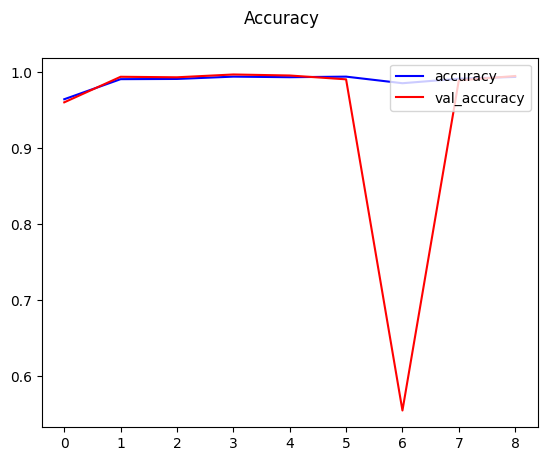

In [92]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy')
plt.legend(loc="upper right")
plt.show()

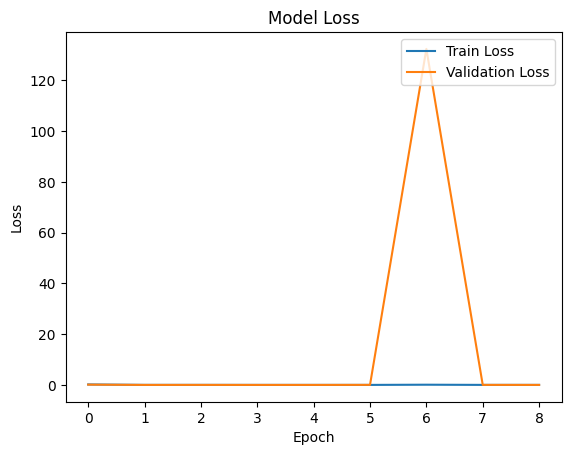

In [ ]:
# Plot Loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(0, 0.2)  # Set y-axis range to [0, 1]
plt.legend(loc='upper right')
plt.show()

Input image shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[7.9055446e-18 1.0000000e+00 8.5890626e-23 5.2524095e-24]]
(1, 4)
1
Input image shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[1.000000e+00 1.690339e-11 8.246348e-14 1.027095e-13]]
(1, 4)
0
Input image shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[2.0284777e-08 2.9666646e-06 9.9999702e-01 1.4456865e-08]]
(1, 4)
2


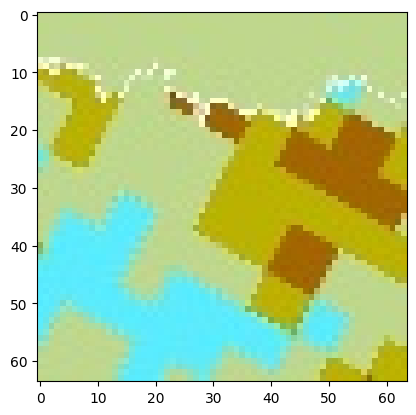

In [94]:
# Inference
from keras.preprocessing import image

img_paths = [
    './data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/processed/Highest_moisture/soil_moisture_india_and_sri_lanka_2015-04-08_class_5_patch_14.png',
    './data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/processed/Dry/_0_108.jpeg',
    './data/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/processed/Moderate_moisture/_0_1004.jpeg',
]

for img_path in img_paths:
    img = image.load_img(img_path, target_size=(HyperParameter.IMG_SIZE, HyperParameter.IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    # x = preprocess_input(x)
    print('Input image shape:', x.shape)
    my_image = cv2.imread(img_path)
    viewImage(my_image)
    inference = model.predict(x)
    print(inference)
    print(inference.shape)
    print(np.argmax(inference))